In [37]:
import tensorflow as tf
import pandas as pd
df = pd.read_csv("S3392.csv")
df.head()

,id,0,1,2,3,4,5,6,7,8,...,25,26,27,28,29,30,31,32,33,34
0,0,1A5E,L_121_R,0,0,0,1,0,0,0,...,-2.50,0.0,1.0,9.68,5.78,0.430041,0.548504,0.061062,0.061062,0.66
1,1,1A5E,L_37_S,0,0,0,0,0,0,0,...,-0.18,0.0,0.0,9.68,7.14,0.118309,0.892136,0.030973,0.070796,0.71
2,2,1A5E,W_15_D,0,-1,0,0,0,0,0,...,-0.90,0.0,-1.0,1.25,5.49,-0.348580,-0.444742,0.009735,0.007965,0.17
3,3,1A5E,D_74_N,0,0,0,0,0,0,0,...,-0.78,-1.0,0.0,5.49,3.93,1.426419,0.907021,0.165487,0.089381,-2.00
4,4,1A5E,P_81_L,0,0,0,0,0,0,0,...,1.10,0.0,0.0,5.02,9.68,1.845905,1.250311,0.225664,0.129204,0.00


In [68]:
df_data = df.iloc[:,23:35].values
df_target = df['34'].values

In [69]:
df_data[0]

array([ 1.66700000e+02,  1.73400000e+02,  1.10000000e+00, -2.50000000e+00,
        0.00000000e+00,  1.00000000e+00,  9.68000000e+00,  5.78000000e+00,
        4.30041430e-01,  5.48503760e-01,  6.10619469e-02,  6.10619469e-02])

In [70]:
from sklearn.model_selection import train_test_split

train_data, test_data, train_targets, test_targets = train_test_split(df_data, df_target, test_size=0.2, random_state=5)

In [71]:
import numpy as np
mean = train_data.mean(axis=0)
train_data -= mean
std = train_data.std(axis=0)
train_data /= std

test_data -= mean
test_data /= std

In [72]:
from keras import models
from keras import layers

def build_model():
    # Because we will need to instantiate
    # the same model multiple times,
    # we use a function to construct it.
    model = models.Sequential()
    model.add(layers.Dense(12, activation='relu',
                           input_shape=(train_data.shape[1],)))
    model.add(layers.Dense(6, activation='relu'))
    model.add(layers.Dense(1))
    model.compile(optimizer='adam', loss='mae', metrics=['mae'])
    return model

In [73]:
import numpy as np

k = 10
num_val_samples = len(train_data) // k
num_epochs = 500
all_scores = []
for i in range(k):
    print('processing fold #', i)
    # Prepare the validation data: data from partition # k
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]

    # Prepare the training data: data from all other partitions
    partial_train_data = np.concatenate(
        [train_data[:i * num_val_samples],
         train_data[(i + 1) * num_val_samples:]],
        axis=0)
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples],
         train_targets[(i + 1) * num_val_samples:]],
        axis=0)

    # Build the Keras model (already compiled)
    model = build_model()
    # Train the model (in silent mode, verbose=0)
    model.fit(partial_train_data, partial_train_targets,
              epochs=num_epochs, batch_size=128, verbose=0)
    # Evaluate the model on the validation data
    val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=0)
    all_scores.append(val_mae)

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3
processing fold # 4
processing fold # 5
processing fold # 6
processing fold # 7
processing fold # 8
processing fold # 9


In [74]:
all_scores

[1.0760722160339355,
 1.069563865661621,
 1.0419089794158936,
 1.0574804544448853,
 1.1272143125534058,
 1.0804009437561035,
 0.9561892747879028,
 1.0607417821884155,
 0.9427245259284973,
 1.0894931554794312]

In [75]:
np.mean(all_scores)

1.0501789510250092

In [76]:
from keras import backend as K

# Some memory clean-up
K.clear_session()

In [77]:
num_epochs = 500
all_mae_histories = []
for i in range(k):
    print('processing fold #', i)
    # Prepare the validation data: data from partition # k
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]

    # Prepare the training data: data from all other partitions
    partial_train_data = np.concatenate(
        [train_data[:i * num_val_samples],
         train_data[(i + 1) * num_val_samples:]],
        axis=0)
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples],
         train_targets[(i + 1) * num_val_samples:]],
        axis=0)

    # Build the Keras model (already compiled)
    model = build_model()
    # Train the model (in silent mode, verbose=0)
    history = model.fit(partial_train_data, partial_train_targets,
                        validation_data=(val_data, val_targets),
                        epochs=num_epochs, batch_size=128, verbose=0)
    mae_history = history.history['val_mae']
    all_mae_histories.append(mae_history)

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3
processing fold # 4
processing fold # 5
processing fold # 6
processing fold # 7
processing fold # 8
processing fold # 9


In [78]:


average_mae_history = [
    np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]



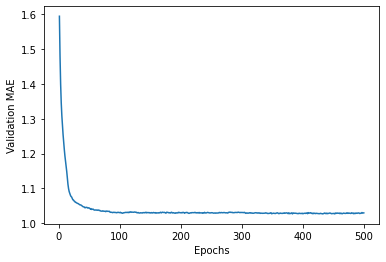

In [79]:
import matplotlib.pyplot as plt

plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

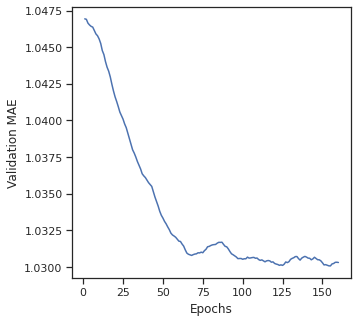

In [178]:
def smooth_curve(points, factor=0.9):
  smoothed_points = []
  for point in points:
    if smoothed_points:
      previous = smoothed_points[-1]
      smoothed_points.append(previous * factor + point * (1 - factor))
    else:
      smoothed_points.append(point)
  return smoothed_points

smooth_mae_history = smooth_curve(average_mae_history[40:200])

plt.plot(range(1, len(smooth_mae_history) + 1), smooth_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

In [189]:
test_data = np.nan_to_num(test_data, copy=True, nan=0.0, posinf=None, neginf=None)
#import random
#random.seed(2016)
# Get a fresh, compiled model.
model = build_model()
# Train it on the entirety of the data.
model.fit(train_data, train_targets,
          epochs=70, batch_size=128, verbose=0)
test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)



679/679 [==============================] - 0s 63us/step


In [190]:
test_mae_score

1.0414258241653442

In [191]:
np.sqrt(test_mse_score)

1.0205026880818895

In [192]:
pr = list(model.predict(test_data))
lst_pr = []
for x in pr:
    lst_pr.append(float(x))
np.corrcoef(lst_pr,test_targets)[0][1]

0.5557566772162459

Text(0.5, 0, 'measured ddG')

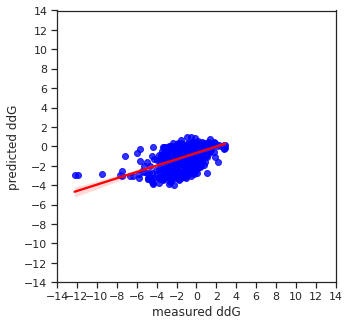

In [148]:
sns.set(rc={'figure.figsize':(5,5)})
sns.set_style('ticks')

gb1 = sns.regplot(y = lst_pr,
                  x = test_targets,
                  scatter_kws={'color':'blue'},
                  line_kws = {'color':'red'})
gb1.set_xticks([-14,-12,-10,-8,-6,-4,-2,0,2,4,6,8,10,12,14])
gb1.set_yticks([-14,-12,-10,-8,-6,-4,-2,0,2,4,6,8,10,12,14])
gb1.set_ylabel('predicted ddG')
gb1.set_xlabel('measured ddG')

Text(0.5, 0, 'measured ddG')

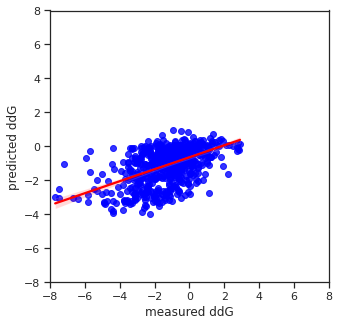

In [149]:
lst_pr_8 = []
test_targets_8 = []
for i in range(len(lst_pr)):
    if test_targets[i] < -8:
        continue
    else:
        lst_pr_8.append(lst_pr[i])
        test_targets_8.append(test_targets[i])
        
sns.set(rc={'figure.figsize':(5,5)})
sns.set_style('ticks')

gb1 = sns.regplot(y = lst_pr_8,
                  x = test_targets_8,
                  scatter_kws={'color':'blue'},
                  line_kws = {'color':'red'})
gb1.set_xticks([-8,-6,-4,-2,0,2,4,6,8])
gb1.set_yticks([-8,-6,-4,-2,0,2,4,6,8])
gb1.set_ylabel('predicted ddG')
gb1.set_xlabel('measured ddG')

In [150]:
K = 10
MAE = []
RMSE = []
R = []
for i in range(K):
    model = build_model()
# Train it on the entirety of the data.
    model.fit(train_data, 
              train_targets,
              epochs=60, batch_size=128, verbose=0)
    test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)
    pr = list(model.predict(test_data))
    lst_pr = []
    for x in pr:
        lst_pr.append(float(x))

    MAE.append(test_mae_score)
    RMSE.append(np.sqrt(test_mse_score))
    R.append(np.corrcoef(lst_pr,test_targets)[0][1])
    
#print("MAE:",MAE)
#print("RMSE:",RMSE)
#print("R:",R)

679/679 [==============================] - 0s 70us/step
MAE: [1.0471237897872925, 1.0490273237228394, 1.039860725402832, 1.0312297344207764, 1.0243433713912964, 1.048633098602295, 1.06223726272583, 1.0350948572158813, 1.0428553819656372, 1.0473759174346924]
RMSE: [1.0232907047471094, 1.0242203415757123, 1.019735567192843, 1.0154947630190794, 1.0120985534571576, 1.024027946190012, 1.0306489157301892, 1.0173961621240553, 1.0212029015649635, 1.0234138560145953]
R: [0.5397039143549764, 0.5454392127153349, 0.5525565877012842, 0.5460366682583915, 0.5632746439185902, 0.5408320298229778, 0.5189566568518086, 0.5612684018253591, 0.5434673247952606, 0.5379854478696102]


In [175]:
print("mean MAE:",np.mean(MAE))
print("mean RMSE:",np.mean(RMSE))
print("mean R:",np.mean(R))

mean MAE: 1.0427781462669372
mean RMSE: 1.0211529711615717
mean R: 0.5449520888113593


In [151]:
model.save('M3392')

In [152]:
from tensorflow import keras
model = keras.models.load_model('M3392')

In [153]:
import pandas as pd
Gb1 = pd.read_csv("Gb1_dataset.csv")
Gb1.head()


,lable,Q,W,E,R,T,Y,I,P,A,...,H_mut,C_wild,C_mut,O_wild,O_mut,w_mrf_v,m_mrf_v,w_p,m_p,ddG
0,N37P,0,0,0,0,0,0,0,1,0,...,0.12,0,0.0,3.93,5.02,4.018893,-1.461790,0.620690,0.0,-3.694
1,A20P,0,0,0,0,0,0,0,1,-1,...,0.12,0,0.0,8.76,5.02,5.865249,-0.839895,0.862069,0.0,-3.480
2,Y33G,0,0,0,0,0,-1,0,0,0,...,0.48,0,0.0,2.91,7.03,3.960331,-1.477268,0.551724,0.0,-3.459
3,V39D,0,0,0,0,0,0,0,0,0,...,-0.90,0,-1.0,6.73,5.49,4.278831,-1.187516,0.482759,0.0,-3.414
4,T51D,0,0,0,0,-1,0,0,0,0,...,-0.90,0,-1.0,5.53,5.49,4.822475,-1.227427,0.862069,0.0,-3.311


In [154]:
Gb1_data = Gb1.iloc[:,21:33].values
Gb1_target = Gb1['ddG'].values

In [155]:
#train_data = Gb1_data

In [156]:
import numpy as np
mean = Gb1_data.mean(axis=0)
Gb1_data -= mean
std = Gb1_data.std(axis=0)
Gb1_data /= std


In [157]:
Gb1_data

array([[-0.41192446, -0.75875645, -0.79241636, ..., -0.76509507,
         0.39163117, -0.46844957],
       [-1.17374768, -0.75875645,  0.86767777, ..., -0.42703302,
         1.75413244, -0.46844957],
       [ 1.96317147, -2.19586525,  0.44079642, ..., -0.77350924,
         0.0023451 , -0.46844957],
       ...,
       [ 0.31404826,  0.7166024 , -0.7449851 , ...,  0.5646799 ,
         0.58627421,  0.20540337],
       [-0.35217362,  1.35046027,  0.07320415, ...,  1.13091663,
         0.19698814,  0.20540337],
       [ 0.31404826,  1.35046027, -0.7449851 , ...,  0.93093418,
         0.58627421,  0.20540337]])

In [193]:
Gb1_mpr = model.predict(Gb1_data)

In [194]:
Gb1_pr = []
for x in Gb1_mpr:
    Gb1_pr.append(x[0])
    
np.corrcoef(Gb1_pr,Gb1_target)[0][1]

0.5420539212637914

In [195]:
import matplotlib.pyplot as plt
import seaborn as sns

Text(0.5, 0, 'measured ddG')

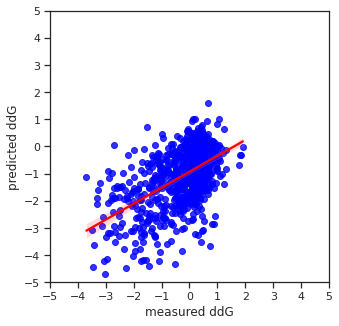

In [196]:
sns.set(rc={'figure.figsize':(5,5)})
sns.set_style('ticks')

gb1 = sns.regplot(y = Gb1_pr,
                  x = Gb1_target,
                  scatter_kws={'color':'blue'},
                  line_kws = {'color':'red'})
gb1.set_xticks([-5,-4,-3,-2,-1,0,1,2,3,4,5])
gb1.set_yticks([-5,-4,-3,-2,-1,0,1,2,3,4,5])
gb1.set_ylabel('predicted ddG')
gb1.set_xlabel('measured ddG')